In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf
from scipy.stats import spearmanr

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_FILE = "/work/mk423/Social_v_1_2/SocialData_v_1_2.pkl"

keep_mice_1 = "/work/mk423/Social_v_1_2/SocialMice_Format1.xlsx"
keep_mice_2 = "/work/mk423/Social_v_1_2/SocialMice_Format2.xlsx"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"

FEATURE_LIST = ['X_psd','X_coh','X_gc']
FEATURE_WEIGHT = [10,1,1]

dataDict = pickle.load(open(DATA_FILE,"rb"))

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
df_f1 = pd.read_excel(keep_mice_1)
df_f2 = pd.read_excel(keep_mice_2)

X = np.hstack([weight*dataDict[feature] for weight,feature in zip(FEATURE_WEIGHT,FEATURE_LIST)])
y_time = dataDict['y_time']
y_mouse = np.array(dataDict['y_mouse'])
y_expDate = np.array(dataDict["y_expDate"])
y_social = np.array(dataDict["y_social"])
y_object = np.array(dataDict["y_object"])
y_velocity = np.array(dataDict["y_velocity"])

s = model.project(X)
coeffs = model.classifier[0].weight[0].detach().cpu().numpy()
agg_score = s[:,:3] @ coeffs

In [3]:
np.unique(y_mouse).shape

(28,)

In [3]:
net_mean = []
net_sterr = []

net_rho2_mean = []
net_rho2_sterr = []

nan_mask = ~np.isnan(y_velocity)
for net in range(30):
    rho_list = []
    rho_2_list = []
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        mask = np.logical_and(mouse_mask,nan_mask)
        
        mouse_rho_list = []
        for expDate in np.unique(y_expDate):
            
            expDate_mask = y_expDate==expDate
            temp_mask = np.logical_and(mask,expDate_mask)
            
            if np.sum(temp_mask) > 0:
                result = spearmanr(s[temp_mask==1,net],y_velocity[temp_mask==1])
                mouse_rho_list.append(result.correlation)
            
        rho_list.append(np.mean(mouse_rho_list))
        rho_2_list.append(np.mean(np.array(mouse_rho_list)**2))
        
        
    net_mean.append(np.mean(rho_list))
    net_sterr.append(np.std(rho_list)/np.sqrt(len(rho_list)))
        
        
    net_rho2_mean.append(np.mean(rho_2_list))
    net_rho2_sterr.append(np.std(rho_2_list)/np.sqrt(len(rho_2_list)))

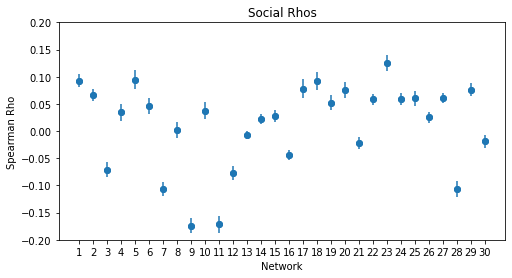

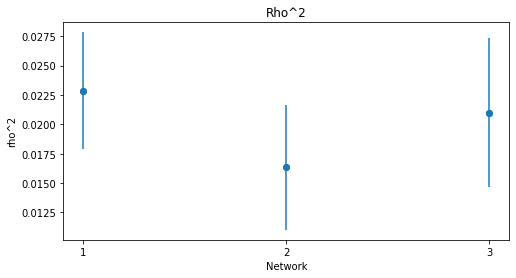

In [4]:
plt.figure(figsize=(8,4))
plt.scatter(range(30),net_mean)
plt.errorbar(range(30),net_mean,net_sterr,fmt="o")
plt.ylabel("Spearman Rho")
plt.xlabel("Network")
plt.xticks(range(30),np.arange(30) + 1)
plt.ylim([-.2,.2])
plt.title("Social Rhos")
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(range(3),net_rho2_mean[:3])
plt.errorbar(range(3),net_rho2_mean[:3],net_rho2_sterr[:3],fmt="o")
plt.ylabel("rho^2")
plt.xlabel("Network")
plt.xticks(range(3),np.arange(3) + 1)
plt.title("Rho^2")
plt.show()

In [19]:
projectDict = {}
projectDict["mouse"] = []
projectDict["expDate"] = []
projectDict["social"] = []
projectDict["object"] = []
projectDict["velocity"] = []
projectDict["agg score"] = []
projectDict["net 1 score"] = []
projectDict["net 2 score"] = []
projectDict["net 3 score"] = []


for idx in range(df_f1.shape[0]):
    
    mouse = "Mouse" + ''.join(df_f1.values[idx,0].split('-'))
    expDate = str(df_f1.values[idx,1])
    
    if len(expDate) < 6:
        expDate = '0' + expDate
    mouse_mask = y_mouse == mouse
    expDate_mask = y_expDate == expDate
    mask = np.logical_and(mouse_mask,expDate_mask)
    
    if np.sum(mask) > 0:
        #statistical test for the third network
        projectDict["mouse"].append(y_mouse[mask==1])
        projectDict["expDate"].append(y_expDate[mask==1])
        projectDict["social"].append(y_social[mask==1])
        projectDict["object"].append(y_object[mask==1])
        projectDict["velocity"].append(y_velocity[mask==1])

        projectDict["agg score"].append(agg_score[mask==1])
        projectDict["net 1 score"].append(s[mask==1,0])
        projectDict["net 2 score"].append(s[mask==1,1])
        projectDict["net 3 score"].append(s[mask==1,2])
    



for idx in range(df_f2.shape[0]):
    
    mouse = df_f2.values[idx,0]
    expDate = str(df_f2.values[idx,1])
    
    if len(expDate) < 6:
        expDate = '0' + expDate
        
    mouse_mask = y_mouse == mouse
    expDate_mask = y_expDate == expDate
    mask = np.logical_and(mouse_mask,expDate_mask)
    
    if np.sum(mask) > 0:
        #statistical test for the third network
        projectDict["mouse"].append(y_mouse[mask==1])
        projectDict["expDate"].append(y_expDate[mask==1])
        projectDict["social"].append(y_social[mask==1])
        projectDict["object"].append(y_object[mask==1])
        projectDict["velocity"].append(y_velocity[mask==1])

        projectDict["agg score"].append(agg_score[mask==1])
        projectDict["net 1 score"].append(s[mask==1,0])
        projectDict["net 2 score"].append(s[mask==1,1])
        projectDict["net 3 score"].append(s[mask==1,2])

projectDict["mouse"] = np.hstack(projectDict["mouse"])
projectDict["expDate"] = np.hstack(projectDict["expDate"])
projectDict["social"] = np.hstack(projectDict["social"])
projectDict["object"] = np.hstack(projectDict["object"])
projectDict["velocity"] = np.hstack(projectDict["velocity"])
projectDict["agg score"] = np.hstack(projectDict["agg score"])
projectDict["net 1 score"] = np.hstack(projectDict["net 1 score"])
projectDict["net 2 score"] = np.hstack(projectDict["net 2 score"])
projectDict["net 3 score"] = np.hstack(projectDict["net 3 score"])

df = pd.DataFrame.from_dict(projectDict)
df.head()

,mouse,expDate,social,object,velocity,agg score,net 1 score,net 2 score,net 3 score
0,Mouse5321,052616,False,True,NaN,2.383564,0.068867,0.100001,0.057580
1,Mouse5321,052616,False,True,0.472884,3.109647,0.101021,0.123141,0.092574
2,Mouse5321,052616,False,True,2.429704,4.365631,0.129303,0.184024,0.042581
3,Mouse5321,052616,False,True,3.007293,2.903649,0.113782,0.105590,0.039570
4,Mouse5321,052616,False,True,1.941513,5.840670,0.174931,0.246522,0.023311


In [1]:
include_mice = ["Mouse0630",
"Mouse0631",
"Mouse0632",
"Mouse0633",
"Mouse0634",
"Mouse0640",
"Mouse0641",
"Mouse0642",
"Mouse0643",
"Mouse0644",
"Mouse5321",
"Mouse5331",
"Mouse5332",
"Mouse5333",
"Mouse533L",
"Mouse6662",
"Mouse6664",
"Mouse6674",
"Mouse6990",
"Mouse6991",
"Mouse6992",
"Mouse699L",
"Mouse8881",
"Mouse8894"]


In [2]:
len(include_mice)

24

In [20]:
mouse_list = []
expDate_list = []

s_agg_score_list = []
s_net_1_list = []
s_net_2_list = []
s_net_3_list = []

o_agg_score_list = []
o_net_1_list = []
o_net_2_list = []
o_net_3_list = []

for mouse in include_mice:
    mouse_mask = df["mouse"] == mouse
    expDates = np.unique(df[mouse_mask==1]["expDate"])
    
    #for expDate in expDates:
        #expDate_mask = df["expDate"]==expDate
        
    mask = mouse_mask #np.logical_and(mouse_mask,expDate_mask)
    if np.sum(mask) > 0:
        o_mask = np.logical_and(mask,df["object"]==1)
        s_mask = np.logical_and(mask,df["social"]==1)

        mouse_list.append(mouse)
        #expDate_list.append(expDate)
        s_agg_score_list.append(np.mean(df[s_mask==1]["agg score"]))
        s_net_1_list.append(np.mean(df[s_mask==1]["net 1 score"]))
        s_net_2_list.append(np.mean(df[s_mask==1]["net 2 score"]))
        s_net_3_list.append(np.mean(df[s_mask==1]["net 3 score"]))

        o_agg_score_list.append(np.mean(df[o_mask==1]["agg score"]))
        o_net_1_list.append(np.mean(df[o_mask==1]["net 1 score"]))
        o_net_2_list.append(np.mean(df[o_mask==1]["net 2 score"]))
        o_net_3_list.append(np.mean(df[o_mask==1]["net 3 score"]))
        
        
        
                        

In [21]:
means_dict = {
    "mouse":mouse_list,
    #"expDate":expDate_list,
    "social mean agg":s_agg_score_list,
    "social mean net 1":s_net_1_list,
    "social mean net 2":s_net_2_list,
    "social mean net 3":s_net_3_list,
    "object mean agg":o_agg_score_list,
    "object mean net 1":o_net_1_list,
    "object mean net 2":o_net_2_list,
    "object mean net 3":o_net_3_list,
}
 
df = pd.DataFrame.from_dict(means_dict)
df.to_csv(PROJECT_PATH + "Anx_Nets_Social_vs_Object_means.csv",index=False)
df.head()

,mouse,social mean agg,social mean net 1,social mean net 2,social mean net 3,object mean agg,object mean net 1,object mean net 2,object mean net 3
0,Mouse0630,4.189760,0.120192,0.179339,0.030794,4.321705,0.122935,0.185761,0.028046
1,Mouse0631,3.449790,0.098050,0.147030,0.052390,3.514428,0.097990,0.151137,0.047892
2,Mouse0632,4.366596,0.106258,0.197735,0.039906,4.410421,0.109559,0.198582,0.036270
3,Mouse0633,3.868243,0.113798,0.163822,0.030577,3.928467,0.115123,0.166750,0.028410
4,Mouse0634,4.678820,0.122561,0.207272,0.030961,4.672527,0.121370,0.207661,0.029415


In [16]:
df

,mouse,expDate,social mean agg,social mean net 1,social mean net 2,social mean net 3,object mean agg,object mean net 1,object mean net 2,object mean net 3
0,Mouse0630,091517,4.223967,0.119227,0.182319,0.022463,4.083088,0.126417,0.170026,0.013720
1,Mouse0630,091817,4.001165,0.117308,0.169817,0.028620,4.372710,0.122310,0.189299,0.025475
2,Mouse0630,092017,4.375191,0.122615,0.188947,0.032870,4.496397,0.126397,0.194356,0.024548
3,Mouse0630,092217,4.123518,0.121310,0.174641,0.032378,4.205983,0.123489,0.178319,0.032101
4,Mouse0630,092517,4.095177,0.119953,0.173868,0.029393,4.461584,0.127253,0.191792,0.023939
...,...,...,...,...,...,...,...,...,...,...
200,Mouse8894,092617,3.190023,0.103635,0.127030,0.078645,3.040766,0.100337,0.120299,0.072129
201,Mouse8894,093017,4.071241,0.120479,0.170162,0.074592,3.997804,0.116425,0.168340,0.069962
202,Mouse8894,100317,4.487424,0.134648,0.186855,0.073324,4.578022,0.133420,0.193100,0.071245
203,Mouse8894,100517,3.751995,0.118079,0.152885,0.063987,3.649908,0.115031,0.148179,0.072625


0.08894326347390198 0.0135627557354488


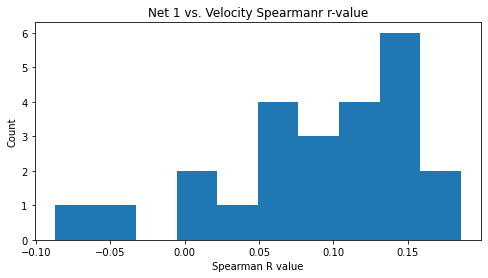

In [18]:
pval_list = []
rval_list = []
for mouse in include_mice:
    mouse_mask = df["mouse"]==mouse
    nan_mask = ~np.isnan(df["velocity"])
    mask = np.logical_and(mouse_mask,nan_mask)
    
    mouse_rhos = []
    for expDate in np.unique(df["expDate"][mask==1]):
        expDate_mask = df["expDate"]==expDate
        sub_mask = np.logical_and(mask,expDate_mask)
        result = spearmanr(df[sub_mask==1]["velocity"],df[sub_mask==1]["net 1 score"])
        mouse_rhos.append(result.correlation)
    rval_list.append(np.mean(mouse_rhos))
    #print(mouse, np.mean(mouse_rhos))
    
print(np.mean(rval_list),np.std(rval_list)/np.sqrt(len(rval_list)))
plt.figure(figsize=(8,4))
plt.hist(rval_list)
plt.ylabel("Count")
plt.xlabel("Spearman R value")
plt.title("Net 1 vs. Velocity Spearmanr r-value")
plt.show()

0.06683998318791261 0.01304988481758718


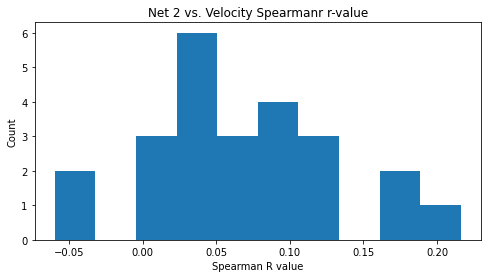

In [16]:
pval_list = []
rval_list = []
for mouse in include_mice:
    mouse_mask = df["mouse"]==mouse
    nan_mask = ~np.isnan(df["velocity"])
    mask = np.logical_and(mouse_mask,nan_mask)
    
    mouse_rhos = []
    for expDate in np.unique(df["expDate"][mask==1]):
        expDate_mask = df["expDate"]==expDate
        sub_mask = np.logical_and(mask,expDate_mask)
        result = spearmanr(df[sub_mask==1]["velocity"],df[sub_mask==1]["net 2 score"])
        mouse_rhos.append(result.correlation)
    
    rval_list.append(np.mean(mouse_rhos))
    #print(mouse, np.mean(mouse_rhos))
    
print(np.mean(rval_list),np.std(rval_list)/np.sqrt(len(rval_list)))
plt.figure(figsize=(8,4))
plt.hist(rval_list)
plt.ylabel("Count")
plt.xlabel("Spearman R value")
plt.title("Net 2 vs. Velocity Spearmanr r-value")
plt.show()

-0.06607905393677314 0.014606130204013799


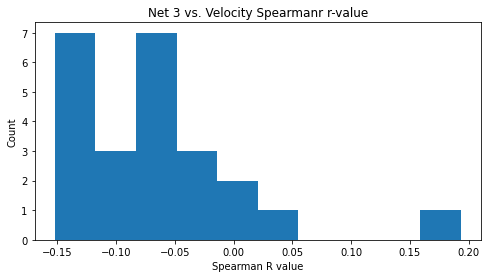

In [17]:
pval_list = []
rval_list = []
for mouse in include_mice:
    mouse_mask = df["mouse"]==mouse
    nan_mask = ~np.isnan(df["velocity"])
    mask = np.logical_and(mouse_mask,nan_mask)
    
    mouse_rhos = []
    for expDate in np.unique(df["expDate"][mask==1]):
        expDate_mask = df["expDate"]==expDate
        sub_mask = np.logical_and(mask,expDate_mask)
        result = spearmanr(df[sub_mask==1]["velocity"],df[sub_mask==1]["net 3 score"])
        mouse_rhos.append(result.correlation)
    
    rval_list.append(np.mean(mouse_rhos))
    #print(mouse, np.mean(mouse_rhos))
    
print(np.mean(rval_list),np.std(rval_list)/np.sqrt(len(rval_list)))
plt.figure(figsize=(8,4))
plt.hist(rval_list)
plt.ylabel("Count")
plt.xlabel("Spearman R value")
plt.title("Net 3 vs. Velocity Spearmanr r-value")
plt.show()

Mouse0630 Number of Windows:  5829
Mouse0631 Number of Windows:  3869
Mouse0632 Number of Windows:  5610
Mouse0633 Number of Windows:  5199
Mouse0634 Number of Windows:  5547
Mouse0640 Number of Windows:  5505
Mouse0641 Number of Windows:  4663
Mouse0642 Number of Windows:  3758
Mouse0643 Number of Windows:  5878
Mouse0644 Number of Windows:  5373
Mouse5321 Number of Windows:  3494
Mouse5331 Number of Windows:  2787
Mouse5332 Number of Windows:  4058
Mouse5333 Number of Windows:  4986
Mouse533L Number of Windows:  3007
Mouse6662 Number of Windows:  4728
Mouse6664 Number of Windows:  3930
Mouse6674 Number of Windows:  4103
Mouse6990 Number of Windows:  2809
Mouse6991 Number of Windows:  3642
Mouse6992 Number of Windows:  4742
Mouse699L Number of Windows:  3197
Mouse8881 Number of Windows:  5409
Mouse8894 Number of Windows:  5629


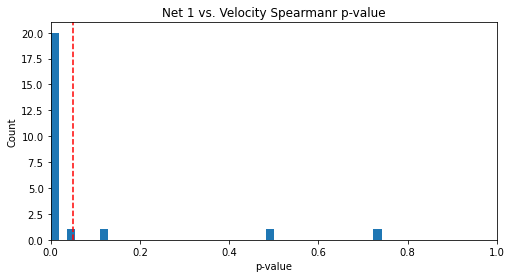

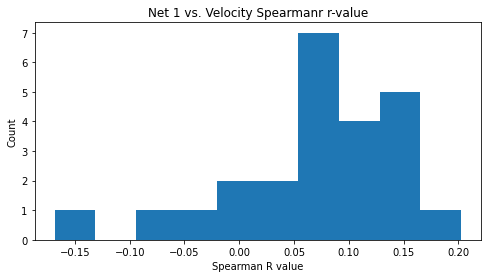

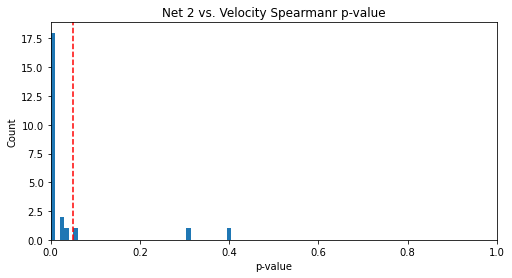

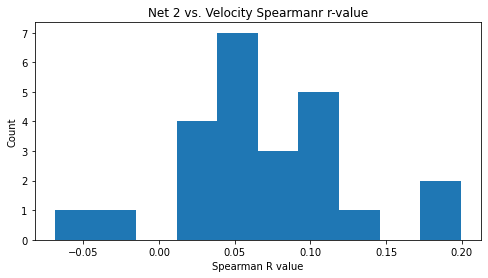

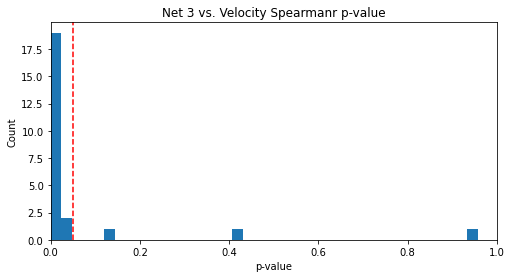

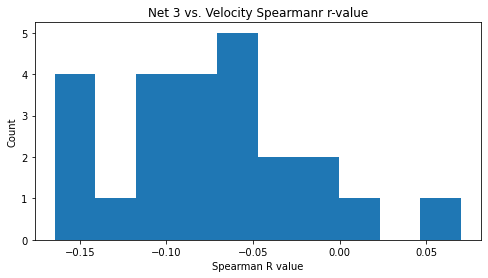

In [61]:
pval_list = []
rval_list = []
for mouse in include_mice:
    mouse_mask = df["mouse"]==mouse
    nan_mask = ~np.isnan(df["velocity"])
    mask = np.logical_and(mouse_mask,nan_mask)
    
    for expDate in np.unique(df["expDate"][mask==1]):
        expDate_mask = df["expDate"]==expDate
        sub_mask = np.logical_and(mask,expDate_mask)
        result = spearmanr(df[mask==1]["velocity"],df[mask==1]["net 1 score"])
        
    pval_list.append(result.pvalue)
    rval_list.append(result.correlation)
    print(mouse, "Number of Windows: ",np.sum(mask))
    
plt.figure(figsize=(8,4))
plt.hist(pval_list,bins=40)
plt.xlim([0,1])
plt.axvline(0.05,linestyle="dashed",color="red",label="p = 0.05")
plt.title("Net 1 vs. Velocity Spearmanr p-value")
plt.ylabel("Count")
plt.xlabel("p-value")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(rval_list)
plt.ylabel("Count")
plt.xlabel("Spearman R value")
plt.title("Net 1 vs. Velocity Spearmanr r-value")
plt.show()

pval_list = []
rval_list = []
for mouse in include_mice:
    mouse_mask = df["mouse"]==mouse
    nan_mask = ~np.isnan(df["velocity"])
    mask = np.logical_and(mouse_mask,nan_mask)
    result = spearmanr(df[mask==1]["velocity"],df[mask==1]["net 2 score"])
    pval_list.append(result.pvalue)
    rval_list.append(result.correlation)
    
plt.figure(figsize=(8,4))
plt.hist(pval_list,bins=40)
plt.xlim([0,1])
plt.axvline(0.05,linestyle="dashed",color="red",label="p = 0.05")
plt.title("Net 2 vs. Velocity Spearmanr p-value")
plt.ylabel("Count")
plt.xlabel("p-value")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(rval_list)
plt.ylabel("Count")
plt.xlabel("Spearman R value")
plt.title("Net 2 vs. Velocity Spearmanr r-value")
plt.show()

pval_list = []
rval_list = []
for mouse in include_mice:
    mouse_mask = df["mouse"]==mouse
    nan_mask = ~np.isnan(df["velocity"])
    mask = np.logical_and(mouse_mask,nan_mask)
    result = spearmanr(df[mask==1]["velocity"],df[mask==1]["net 3 score"])
    pval_list.append(result.pvalue)
    rval_list.append(result.correlation)
    
plt.figure(figsize=(8,4))
plt.hist(pval_list,bins=40)
plt.xlim([0,1])
plt.axvline(0.05,linestyle="dashed",color="red",label="p = 0.05")
plt.title("Net 3 vs. Velocity Spearmanr p-value")
plt.ylabel("Count")
plt.xlabel("p-value")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(rval_list)
plt.ylabel("Count")
plt.xlabel("Spearman R value")
plt.title("Net 3 vs. Velocity Spearmanr r-value")
plt.show()

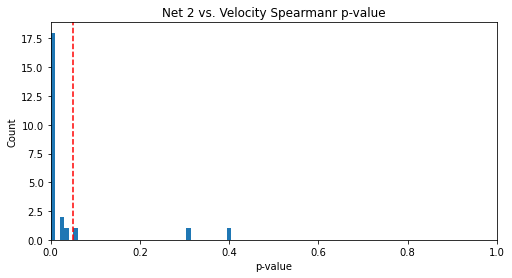

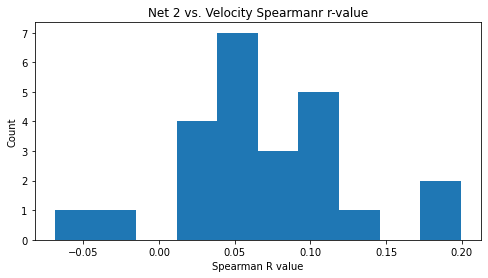

In [55]:
pval_list = []
rval_list = []
for mouse in include_mice:
    mouse_mask = df["mouse"]==mouse
    nan_mask = ~np.isnan(df["velocity"])
    mask = np.logical_and(mouse_mask,nan_mask)
    
    result = spearmanr(df[mask==1]["velocity"],df[mask==1]["net 1 score"])
    pval_list.append(result.pvalue)
    rval_list.append(result.correlation)
    print(mouse, "Number of Windows: ",np.sum(mask))
    
plt.figure(figsize=(8,4))
plt.hist(pval_list,bins=40)
plt.xlim([0,1])
plt.axvline(0.05,linestyle="dashed",color="red",label="p = 0.05")
plt.title("Net 1 vs. Velocity Spearmanr p-value")
plt.ylabel("Count")
plt.xlabel("p-value")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(rval_list)
plt.ylabel("Count")
plt.xlabel("Spearman R value")
plt.title("Net 1 vs. Velocity Spearmanr r-value")
plt.show()

pval_list = []
rval_list = []
for mouse in include_mice:
    mouse_mask = df["mouse"]==mouse
    nan_mask = ~np.isnan(df["velocity"])
    mask = np.logical_and(mouse_mask,nan_mask)
    result = spearmanr(df[mask==1]["velocity"],df[mask==1]["net 2 score"])
    pval_list.append(result.pvalue)
    rval_list.append(result.correlation)
    
plt.figure(figsize=(8,4))
plt.hist(pval_list,bins=40)
plt.xlim([0,1])
plt.axvline(0.05,linestyle="dashed",color="red",label="p = 0.05")
plt.title("Net 2 vs. Velocity Spearmanr p-value")
plt.ylabel("Count")
plt.xlabel("p-value")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(rval_list)
plt.ylabel("Count")
plt.xlabel("Spearman R value")
plt.title("Net 2 vs. Velocity Spearmanr r-value")
plt.show()

pval_list = []
rval_list = []
for mouse in include_mice:
    mouse_mask = df["mouse"]==mouse
    nan_mask = ~np.isnan(df["velocity"])
    mask = np.logical_and(mouse_mask,nan_mask)
    result = spearmanr(df[mask==1]["velocity"],df[mask==1]["net 3 score"])
    pval_list.append(result.pvalue)
    rval_list.append(result.correlation)
    
plt.figure(figsize=(8,4))
plt.hist(pval_list,bins=40)
plt.xlim([0,1])
plt.axvline(0.05,linestyle="dashed",color="red",label="p = 0.05")
plt.title("Net 3 vs. Velocity Spearmanr p-value")
plt.ylabel("Count")
plt.xlabel("p-value")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(rval_list)
plt.ylabel("Count")
plt.xlabel("Spearman R value")
plt.title("Net 3 vs. Velocity Spearmanr r-value")
plt.show()

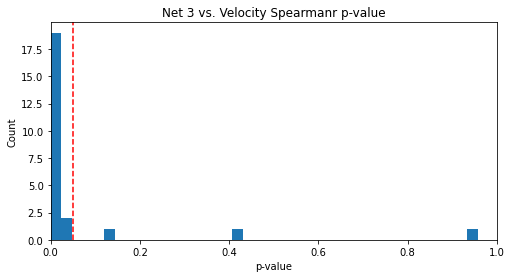

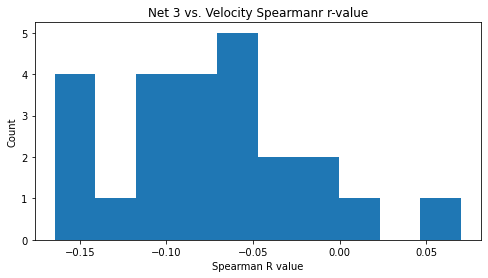

In [51]:
np.unique(y_mouse).shape

(28,)

In [57]:
len(pval_list)

24

In [52]:
np.unique(df['mouse']).shape

(28,)